In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
!wget https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download -O chest_xray.zip
!unzip -q chest_xray.zip

--2025-11-02 12:36:23--  https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Fdatasets%2Fpaultimothymooney%2Fchest-xray-pneumonia%3Fresource%3Ddownload [following]
--2025-11-02 12:36:23--  https://www.kaggle.com/account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Fdatasets%2Fpaultimothymooney%2Fchest-xray-pneumonia%3Fresource%3Ddownload
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘chest_xray.zip’

chest_xray.zip          [ <=>                ]   5.02K  --.-KB/s    in 0s      

2025-11-02 12:36:24 (33.8 MB/s) - ‘

In [ ]:
import os

# Get the current working directory
base_dir = os.getcwd()
print("Base Directory:", base_dir)

# Define dataset paths
train_dir = os.path.join(base_dir, "chest_xray", "train")
test_dir = os.path.join(base_dir, "chest_xray", "test")
val_dir = os.path.join(base_dir, "chest_xray", "val")

print("Train Directory:", train_dir)
print("Test Directory:", test_dir)
print("Validation Directory:", val_dir)


Base Directory: /content
Train Directory: /content/chest_xray/train
Test Directory: /content/chest_xray/test
Validation Directory: /content/chest_xray/val


Connect Kaggle to Colab

Run this first in a Colab cell:

In [ ]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nishitakanojiya17","key":"24d92a5b6d374e9d187722f44b095100"}'}

Set Up Kaggle API


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Download the Chest X-Ray Dataset

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.26G/2.29G [00:32<00:00, 293MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.4MB/s]


In [ ]:
!unzip -q chest-xray-pneumonia.zip -d /content/


In [ ]:
import os

print(os.listdir("/content/chest_xray"))


['test', 'train', 'chest_xray', '__MACOSX', 'val']


In [ ]:
import os

print(os.listdir("/content/chest_xray/chest_xray"))


['test', 'train', '.DS_Store', 'val']


In [ ]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary')
test_set = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model 1: Custom CNN (Baseline)

In [ ]:
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

model_cnn = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/chest_xray/chest_xray/train"
test_dir = "/content/chest_xray/chest_xray/test"
val_dir = "/content/chest_xray/chest_xray/val"


img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


history = model_cnn.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8501 - loss: 0.4395

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.8504 - loss: 0.4386 - val_accuracy: 0.5000 - val_loss: 7.1858
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.9248 - loss: 0.1897 - val_accuracy: 0.5000 - val_loss: 8.9756
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.9271 - loss: 0.1664 - val_accuracy: 0.5625 - val_loss: 3.6912
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.9421 - loss: 0.1529 - val_accuracy: 0.6250 - val_loss: 2.3461
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.9448 - loss: 0.1433 - val_accuracy: 0.6875 - val_loss: 0.5628
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.9359 - loss: 0.1556 - val_accuracy: 0.7500 - val_loss: 0.5498
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.9540 - loss: 0.1207 - val_accuracy: 0.6250 - val_loss: 0.5774
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.9448 - loss: 0.1456 - val_accuracy: 0.562

In [ ]:
test_loss, test_acc = model_cnn.evaluate(test_gen)
print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 625ms/step - accuracy: 0.8430 - loss: 0.3863
 Test Accuracy: 89.26%
 Test Loss: 0.2627


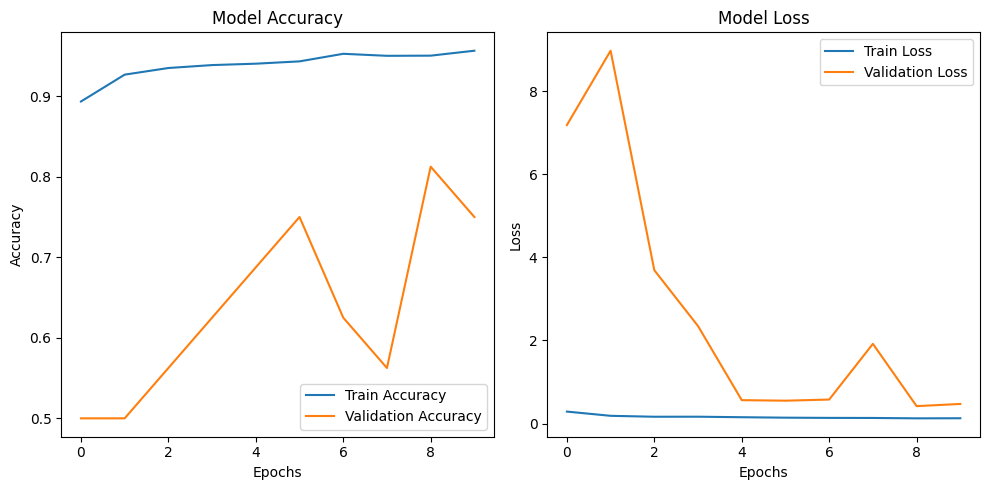

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
